In [ ]:
#    Copyright 2020 Arkadip Bhattacharya

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#        http://www.apache.org/licenses/LICENSE-2.0

#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import dataloader
from sklearn.model_selection import train_test_split
from preprocessing import Normalize_df, WindSpeedDataset, WindSpeedDatasetTimeSeries, ComposeTransform, ToTensor

In [2]:
dataset = Normalize_df(pd.read_csv('./dataset-daily.csv'))
dataset.head()

,time,air_temperature_mean,pressure,wind_direction,wind_speed
0,0.000000,0.370203,0.103164,0.732591,0.625000
1,0.000011,0.322799,0.268912,0.838440,0.354167
2,0.000022,0.302483,0.709078,0.988858,0.260417
3,0.000033,0.246050,0.850758,0.239554,0.093750
4,0.000044,0.194131,0.827372,0.345404,0.291667


In [3]:
trainset, testset = train_test_split(dataset, test_size = 0.1)
trainset, valset = train_test_split(trainset, test_size = 0.1)

In [4]:
trainset.iloc[0]

time                    0.225184
air_temperature_mean    0.668172
pressure                0.303301
wind_direction          0.562674
wind_speed              0.343750
Name: 903, dtype: float64

In [5]:
train_dataset = WindSpeedDatasetTimeSeries(trainset,transform=ComposeTransform([ToTensor()]))
test_dataset = WindSpeedDatasetTimeSeries(testset, transform=ComposeTransform([ToTensor()]))
val_dataset = WindSpeedDatasetTimeSeries(valset, transform=ComposeTransform([ToTensor()]))

In [6]:
train_dataset[0]

(tensor([[0.6682, 0.3033, 0.5627],
         [0.8397, 0.6018, 0.3733],
         [0.4402, 0.2105, 0.5181],
         [0.5779, 0.5454, 0.7242],
         [0.5282, 0.2840, 0.6741],
         [0.7630, 0.2799, 0.5543]], dtype=torch.float64), tensor([[0.3438],
         [0.2396],
         [0.2812],
         [0.4271],
         [0.6354],
         [0.2812]], dtype=torch.float64))

In [7]:
batch_size = 32

trainloader = dataloader.DataLoader(train_dataset, batch_size, shuffle = True)
valloader = dataloader.DataLoader(val_dataset, batch_size, shuffle = False)
testloader = dataloader.DataLoader(test_dataset, batch_size, shuffle = False)

In [8]:
f, l = next(iter(trainloader))

In [9]:
f.shape

torch.Size([32, 6, 3])

In [10]:
l.shape

torch.Size([32, 6, 1])

In [11]:
cuda = torch.cuda.is_available()
device = torch.device('cuda') if cuda else torch.device('cpu')
if cuda:
    print("Device Count:", torch.cuda.device_count())
    print("Device:", torch.cuda.get_device_name())
    print("Device Capability:", torch.cuda.get_device_capability())

Device Count: 1
Device: Tesla K80
Device Capability: (3, 7)


In [14]:
from model import Model
model = Model(3, 100, 1, cuda=cuda)
model.to(device)
print(model)

Model(
  (lstm1): LSTM(3, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [18]:
from torch.optim import Adam
from torch.nn import SmoothL1Loss

trainlosses, testlosses = model.fit(trainloader = trainloader,
                                    validationloader = valloader,
                                    loss = SmoothL1Loss,
                                    optim = Adam,
                                    lr=0.001,
                                    epochs = 20, 
                                    val_per_batch = 20)

Epoch: 1 Batch: 0 out of 93 Training Loss: 9.50202586189393e-05 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 1 out of 93 Training Loss: 0.007422369649453509 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 2 out of 93 Training Loss: 0.016287465324445118 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 3 out of 93 Training Loss: 0.026763507840974678 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 4 out of 93 Training Loss: 0.03475979410652672 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 5 out of 93 Training Loss: 0.043769169343455185 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 6 out of 93 Training Loss: 0.050407962152554144 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 7 out of 93 Training Loss: 0.05812406048719441 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 8 out of 93 Training Loss: 0.07029329028521333 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 9 out of 93 Training Loss: 0.0792357965612844 Test Loss: 0.008060482203621756
Epoch: 1 Batch: 10 out of 93 Training Loss: 0

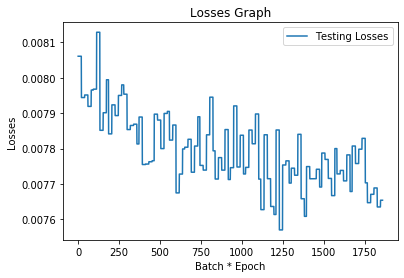

In [20]:
#plt.plot(trainlosses, label = 'Training Losses')
plt.plot(testlosses, label = 'Testing Losses')
plt.ylabel('Losses')
plt.xlabel('Batch * Epoch')
plt.legend()
plt.title('Losses Graph')
plt.show()

In [21]:
result, expected = model.test(testloader)

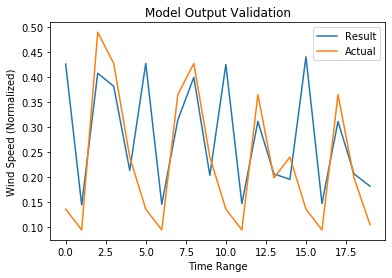

In [23]:
val_from = 40
val_to = 60

plt.plot(result[val_from:val_to], label = 'Result')
plt.plot(expected[val_from:val_to], label = 'Actual')
plt.ylabel('Wind Speed (Normalized)')
#plt.xticks(range(val_from, val_to))
plt.xlabel('Time Range')
plt.legend()
plt.title('Model Output Validation')
plt.show()

In [24]:
model.save('lstm-v2', save_optim=True)

lstm-v2  - dir Created
Model saved in lstm-v2
Optimizer saved in lstm-v2
